## 4-2.  Quantum simulation using Trotter decomposition
In this section, we introduce one method for simulating the dynamics of quantum systems: dynamics simulation based on Trotter decomposition. This method is in a sense the most straightforward method for simulating dynamics, and it works on NISQ devices up to a certain scale of problems.   
Here we try to simulate the quantum dynamics of a physical system, and we focus on the 1D transverse field Ising model.

### Trotter decomposition

The Trotter decomposition is a formula that approximates the exponential function of the sum of square matrices $A,B$ to the product of their respective exponential functions

$$
e^{\delta (A+B)} = e^{\delta A} \cdot e^{\delta B} +  O\left( \delta^2 \right).
$$

$O$ is the order notation introduced in the [section 2.3](2.3_quantum_Fourier_transform.ipynb) column, which represents the approximate accuracy of the approximation. (Note that $e^{A+B}\neq e^A\cdot e^B$ since $A,B$ are matrices that don't necessarily commute).

### Quantum simulation using Trotter decomposition

As we learned in the previous section, the time evolution of a quantum state follows the Schrodinger equation $i\frac{\partial}{\partial t}|\psi(t)\rangle = H|\psi(t)\rangle$ (assuming $\hbar=1$). In particular, if the Hamiltonian $H$ is independent of time, the state after time $t$ is $|\psi(t)\rangle = e^{-iHt}|\psi(0)\rangle$ ($|\psi(0)\rangle$ is the initial state). In other words, in simulating the dynamics of a quantum system, it is enough to calculate the operator $e^{-iHt}$. However, in an $n$-qubit system, $H$ is a $2^n$-dimensional, i.e very large, matrix. Therefore, it is difficult to compute this exponential function with a classical computer, and it is also considered difficult to compute the exponential function of any $2^n$-dimensional matrix $H$ with a quantum computer.

However, if the Hamiltonian has a **specific structure**, a quantum computer can compute $e^{-iHt}$ efficiently. The Trotter decomposition is used for this purpose.   
Let us consider a concrete example. Consider an Ising model consisting of $n$ qubits (see below). The Hamiltonian for this model is given by $H = \sum_{i=1}^{n-1} Z_i Z_{i+1}$. Using the Trotter decomposition, we can decompose $e^{-iH t}$ as

$$
 e^{-iHt} = e^{-i\left(\sum_{i=1}^{n-1} Z_i Z_{i+1}\right) t} = \left(e^{-i(Z_1 Z_2 + Z_2 Z_3 \cdots )\frac{t}{M}}\right)^M
 \approx \left(e^{-i(Z_1 Z_2)\frac{t}{M}}\cdot e^{-i(Z_2 Z_3)\frac{t}{M}}\cdot\cdots \right)^M  \tag{1}
$$

Let $M$ be the total number dividing the action of $e^{-iHt}$, chosen so that the accuracy of the approximation $O\left((t/M)^2\right)$ is enough.   
If we look at the last equation, we see that we need to perform $nM$ products of $e^{-i(Z_i Z_{i+1})\frac{t}{M}}$, which is a small matrix (2-qubit gates, 4 dimensions). In other words, **the action of an exponentially large matrix could be written as polynomial products of small matrices (2-qubit gates)**.

Thus, if the Hamiltonian can be written as a sum of a small number of terms, it can be computed at high speed on a quantum computer using the Trotter decomposition.

*Incidentally, most Hamiltonians of interest in physics and quantum chemistry have a form that allows efficient Trotter decomposition.


### Implementation of quantum dynamics (1): Ising model

Let us consider the Ising model as a concrete system to implement quantum simulation.   
(For readers who are not familiar with physics, we will introduce the necessary concepts needed to follow the calculation.)

The property of matter to respond to a magnetic field is called magnetism, and in the microscopic world, electrons and atomic nuclei have very small magnetic properties, called **spin**. Roughly speaking, we can think of spin as a small magnet. The magnets we see in everyday life are the result of the neat alignment of the small magnetism exhibited by the spins of the electrons (and atomic nuclei) in matter.

The Ising model is a model that describes the behavior of the spins in matter and was invented as a model that extracts the essence of magnets. The definition is as follows:

$$
H = J \sum_{i=1}^{n} Z_i Z_{i+1}
$$

where $J$ is a parameter of the model that determines the strength of the interaction between the spins, $n$ is the number of particles with spin, and $Z_i$ is the $z$-axis component of the spin of the $i$-th particle. As we learned in the previous section, physical quantities are represented by Hermitian operators called observables, so the magnetization (strength of the magnetic force) exhibited by spins is also represented by an operator. Using the $x,y,z$ (Cartesian) coordinate system, the magnetization can be written in terms of the Pauli operators are $X,Y,Z$.
By convention we use the z-direction as the quantization axes which means that $Z|0\rangle=|0\rangle$, $Z|1\rangle= -|1\rangle$. In other words, the state $|0\rangle$ corresponds to the spin facing $+z$ direction and the $|1\rangle$ corresponds to the spin facing the $-z$ direction. In what follow we will consider that each spin is represented by a qubit. So the $i^{th}$ spin = $i^{th}$ qubit. 

The product $Z_i Z_{i+1}$ in this model represent the interaction between neighboring qubits. When $J>0$, $Z_i Z_{i+1}=1$ for $(Z_i,Z_{i+1})=(1,1),(-1,-1)$ and $Z_i Z_{i+1}=-1$ for $(Z_i,Z_{i+1})=(1,-1),(-1,1)$, so the energy is low when the spins point in opposite directions, e.g. $| 010101\cdots\rangle$. Conversely, for $J<0$, the spin-aligned cases $|000\cdots\rangle$ and $|111\cdots\rangle$ have the lowest energy, and the system behaves as a magnet with a large magnetization.

This model can be easily solved without using a quantum computer, but we will use this model as for a first implementation of the Trotter decomposition. The Trotter decomposition of $e^{-iHt}$ is derived in equation (1) but what we need is how to implement the gate $e^{-i \delta Z_i Z_{i+1}}$. This can be done as follows (we leave the mathematical verification as an exercise):
$$
e^{-i \delta Z_i Z_{i+1}} = \operatorname{CNOT}_{i,i+1} \cdot e^{-i\delta Z_{i+1}} \cdot \operatorname{CNOT}_{i,i+1}.
$$

Now, we focus on the physical quantity corresponding to the total magnetization in the z-direction 

$$
\left\langle\psi\left|\sum_{i=1}^{n} Z_i\right|\psi\right\rangle
$$

and follow its time variation.

**The initial state is** $|000\cdots\rangle$ **with spin aligned in the** $+z$ direction, and for convenience, $Z_{n+1}$ is identified with $Z_1$, assuming that the system is periodic.

In [5]:
## Run only if you are in Google Colaboratory or in a local environment where Qulacs is not installed
!pip install qulacs

## Run only in Google Colaboratory or (Linux or Mac) jupyter notebook environment
## Qulacs errors will be output normally.
!pip3 install wurlitzer
%load_ext wurlitzer

In [1]:
#Import required libraries
from qulacs import QuantumState, QuantumCircuit, Observable, PauliOperator
from qulacs.gate import X, Z, RX, RY, RZ, CNOT, merge, DenseMatrix,add
from qulacs.state import inner_product
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

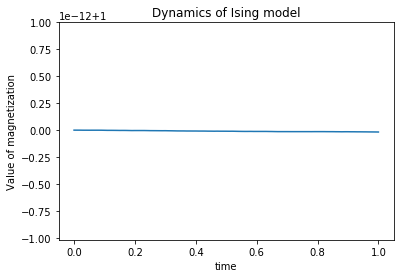

In [2]:
# In this case, we consider a system with six particles.
nqubits = 6

#  Time to simulate dynamics
t = 1.0

# Number of divisions of Trotter decomposition
M = 100

# Time increment range
delta = t/M

## Prepare observable for all magnetizations.
magnetization_obs = Observable(nqubits) 
for i in range(nqubits):
     magnetization_obs.add_operator(PauliOperator("Z "+str(i), 1.0/nqubits))
        
## The initial state is |000000>
state = QuantumState(nqubits)
state.set_zero_state() 

# Convert one Trotter decomposition ,e^{iZ_1Z_2*delta}*e^{iZ_2Z_3*delta}*...e^{iZ_nZ_1*delta} to a quantum gate
circuit_trotter_Ising = QuantumCircuit(nqubits)
for i in range(nqubits):
    circuit_trotter_Ising.add_CNOT_gate(i,(i+1)%(nqubits))
    circuit_trotter_Ising.add_RZ_gate((i+1)%nqubits,2*delta) ## RZ(a)=exp(i*a/2*Z)
    circuit_trotter_Ising.add_CNOT_gate(i,(i+1)%(nqubits))

## A list that records time and magnetization
x = [i*delta for i in range(M+1)]
y = []

#Calculate total magnetization at t=0
y.append( magnetization_obs.get_expectation_value(state) )

#Calculate total magnetization after t=0
for i in range(M):
    # Time evolution by delta=t/M
    circuit_trotter_Ising.update_quantum_state(state)
    # Calculate and record magnetization
    y.append(magnetization_obs.get_expectation_value(state))

#Drawing a graph
plt.xlabel("time")
plt.ylabel("Value of magnetization")
plt.title("Dynamics of Ising model")
plt.plot(x, y, "-")
plt.show()

As can be seen in this result, the total magnetization in the $z$ direction is constant (also note the scale of the vertical axis).
In fact, since the Ising model only interacts in the $z$ direction, the magnetization in the $z$ direction is also conserved. This is not interesting, so let us now look at the time evolution of the transverse magnetic field Ising model with a magnetic field in the $x$  direction.

### Implementation of Quantum Dynamics (2): Transverse Magnetic Field Ising Model
Let's consider a transverse magnetic field Ising model with a uniform magnetic field along the $x$ axis applied to the Ising model.

$$
H = \sum_{i=1}^n Z_i Z_{i+1} + h\sum_{i=1}^n X_i  
$$ 

The $h$ is a coefficient representing the strength of the transverse magnetic field, and $X_i$ is the Pauli operator (observable) representing the magnetization of the $i$th particle in the $x$ direction.

If we perform the Trotter decomposition in this model, we will add the term $e^{-ih X_1 \frac{t}{M}} \cdots e^{-ih X_n \frac{t}{M}}$ in addition to the Ising model described earlier.   
Now let's actually look at the total magnetization in this model.

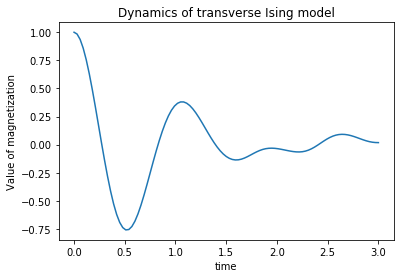

In [3]:
# In this case, we consider a system with six particles.
nqubits = 6
#  Time to simulate dynamics
t = 3.0
# Number of divisions of Trotter decomposition
M = 100
# Time increment range
delta = t/M

## Transverse magnetic field strength
h = 3.

## Prepare observable for all magnetizations.
magnetization_obs = Observable(nqubits) 
for i in range(nqubits):
     magnetization_obs.add_operator(PauliOperator("Z "+str(i), 1.0/nqubits))

## The initial state is |000000>
state = QuantumState(nqubits)
state.set_zero_state() 

# Convert one Trotter decomposition ,e^{iZ_1Z_2*delta}*e^{iZ_2Z_3*delta}*...e^{iZ_nZ_1*delta} to a quantum gate
circuit_trotter_transIsing = QuantumCircuit(nqubits)
for i in range(nqubits):
    circuit_trotter_transIsing.add_CNOT_gate(i,(i+1)%(nqubits))
    circuit_trotter_transIsing.add_RZ_gate((i+1)%nqubits,2*delta) ## RZ(a)=exp(i*a/2*Z)
    circuit_trotter_transIsing.add_CNOT_gate(i,(i+1)%(nqubits))
    circuit_trotter_transIsing.add_RX_gate(i, 2*delta*h) ## RX(a)=exp(i*a/2*X)

## A list that records time and magnetization
x = [i*delta for i in range(M+1)]
y = []

#Calculate total magnetization at t=0
y.append( magnetization_obs.get_expectation_value(state) )

#Calculate total magnetization after t=0
for i in range(M):
    # Time evolution by delta=t/M
    circuit_trotter_transIsing.update_quantum_state(state)
    # Calculate and record magnetization
    y.append(magnetization_obs.get_expectation_value(state))

#Drawing a graph
plt.xlabel("time")
plt.ylabel("Value of magnetization")
plt.title("Dynamics of transverse Ising model")
plt.plot(x, y, "-")
plt.show()

The Ising model with $h=0$ has a constant total magnetization, whereas the transverse field Ising model with a transverse magnetic field of $h=3$ has a significant difference in that the value of total magnetization changes over time and even drops to a negative value. 
This can be thought of as the transverse magnetic field (magnetic field in the $x$ direction) causing the spins that were aligned in the $z$ direction to become disorganized and disordered, resulting in a change in the value of total magnetization. If you are interested, try to calculate with a stronger $h$ value, and you will see that the speed of magnetization decrease becomes faster.

### Implementation of quantum dynamics (3): Comparison with exact solution
There is an error in the Trotter decomposition. Let's compare the dynamics calculated above with the exact dynamics where $e^{-iHt} $ is calculated directly to check its accuracy.

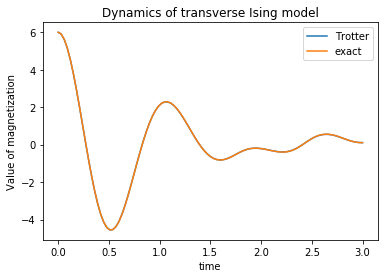

In [4]:
# In this case, we consider a system with six particles.
nqubits = 6
#  Time to simulate dynamics
t = 3.0
# Number of divisions of Trotter decomposition
M = 100
# Time increment range
delta = t/M

# Transverse magnetic field strength
h = 3.

# Prepare observable for all magnetizations.
magnetization_obs = Observable(nqubits) 
for i in range(nqubits):
     magnetization_obs.add_operator(PauliOperator("Z "+str(i), 1.0))

# The initial state is |000000>
state_trotter = QuantumState(nqubits)
state_trotter.set_zero_state() 
state_exact = QuantumState(nqubits)
state_exact.set_zero_state() 

# Convert one Trotter decomposition ,e^{iZ_1Z_2*delta}*e^{iZ_2Z_3*delta}*...e^{iZ_nZ_1*delta} to a quantum gate
circuit_trotter_transIsing = QuantumCircuit(nqubits)
for i in range(nqubits):
    circuit_trotter_transIsing.add_CNOT_gate(i,(i+1)%(nqubits))
    circuit_trotter_transIsing.add_RZ_gate((i+1)%nqubits,2*delta) ## RZ(a)=exp(i*a/2*Z)
    circuit_trotter_transIsing.add_CNOT_gate(i,(i+1)%(nqubits))
    circuit_trotter_transIsing.add_RX_gate(i, 2*delta*h) ## RX(a)=exp(i*a/2*X)

# Diagonalize e^{-iHt} directly. To get the matrix representation of H, generate a gate and get its matrix 
zz_matrix = np.array([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]]) ## matrix representation of Z_i*Z_{i+1}
hx_matrix = h*np.array( [ [0,1], [1,0] ] )
zz = DenseMatrix([0,1], zz_matrix) ## interaction between 0 and 1 
hx = DenseMatrix(0, hx_matrix) ## transeverse magnetic field to 0 sight
## Add interactions and transverse magnetic fields at sight after 1 byqulacs.gate.add. 
for i in range(1, nqubits): 
    zz = add(zz, DenseMatrix([i,(i+1)%nqubits], zz_matrix))
    hx = add(hx, DenseMatrix(i, hx_matrix) ) 
## Final Hamiltonian
ham = add(zz, hx) 
matrix = ham.get_matrix() #get matrix
eigenvalue, P = np.linalg.eigh(np.array(matrix)) #get eigenstate and eigenvector
## create e^{-i*H*delta} as a matrix
e_iHdelta = np.diag(np.exp(-1.0j*eigenvalue*delta))
e_iHdelta = np.dot(P, np.dot(e_iHdelta, P.T))
## convert to circuit
circuit_exact_transIsing = QuantumCircuit(nqubits)
circuit_exact_transIsing.add_dense_matrix_gate( np.arange(nqubits), e_iHdelta)

## A list that records time and magnetization
x = [i*delta for i in range(M+1)]
y_trotter = []
y_exact = []

#Calculate total magnetization at t=0
y_trotter.append( magnetization_obs.get_expectation_value(state_trotter) )
y_exact.append( magnetization_obs.get_expectation_value(state_exact) )

#Calculate total magnetization after t=0
for i in range(M):
    # Time evolution by delta=t/M
    circuit_trotter_transIsing.update_quantum_state(state_trotter)
    circuit_exact_transIsing.update_quantum_state(state_exact)
    # Calculate and record magnetization
    y_trotter.append( magnetization_obs.get_expectation_value(state_trotter) )
    y_exact.append( magnetization_obs.get_expectation_value(state_exact) )

#Drawing a graph
plt.xlabel("time")
plt.ylabel("Value of magnetization")
plt.title("Dynamics of transverse Ising model")
plt.plot(x, y_trotter, "-", label="Trotter")
plt.plot(x, y_exact, "-", label="exact")
plt.legend()
plt.show()

In this range, it seems that they are almost the same. Let's look at the error.

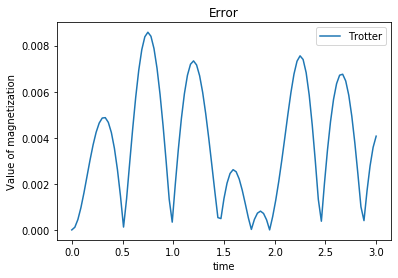

In [5]:
#Drawing a graph
plt.xlabel("time")
plt.ylabel("Value of magnetization")
plt.title("Error")
plt.plot(x, np.abs(np.array(y_trotter) - np.array(y_exact)), "-", label="Trotter")
plt.legend()
plt.show()

We recommend interested readers to decrease division numbers $M$ and increase time $t$.